In [1]:
#!pip install emoji
#!pip install fasttext
#!pip install transformers
#!pip install transformers
#https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d

In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,  Dropout, Input, LSTM, Embedding,SpatialDropout1D, BatchNormalization, Flatten, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import re

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet as wn
from nltk import word_tokenize,pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict        
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path

from livelossplot.inputs.tf_keras import PlotLossesCallback

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import pickle
import fasttext.util

from sklearn.metrics import confusion_matrix

import keras_tuner as kt
import seaborn as sns


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1550788350982241532
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5762973696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7303820942992948759
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
# print(tf.__version__)
# import tensorflow_hub as hub

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)



Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


# Set Parameters

In [4]:
TRAIN_MODE= True
emb_dim=50
batchsize=256

sequence_size= 500
READ_DATA = False
ETL_STOPWORDS= False
FIT_MODEL = False
FIT_ATTENTION_MODELV2 = False
FIT_TRANSFORMER_MODEL = True
ETL_SENTENCE_SIZE = False

MAKE_PREDICTION = True

TUNNING = False
TUNNING_ATTENTION_V2 = False
TUNNING_TRANSFORMER = True

max_trials = 30
threshold = 1
classN=1
tf.random.set_seed(0)
np.random.seed(0)

In [5]:

Emoji_Dict ={
    ":p" : "<>" ,
    ":)" :"<SMILE_SIMPLE>",
    ":(":"<SAD>",
    ":'(":"<CRY>",
    ":')":"<BLINK_EYE>",
    ":d" : "<BIG_SMILE>", 
    ":-)":"<SMILE_HAPPY>",
    ";-)":"<SMILE_A_LOT>",
    ":<})":"<MOUSTACHE_SMILE>",
    ":-||":"<MAD>",
    ":-(":"<SAD>", 
    ":'-(":"<CRY>",
    ":-))":"<HAPPY>",
    ":-*": "<KISS>",
    ":-P~":"<LICK>", 
    ":-o" :"<SURPRISED>",
    ":-|":"<GRIM>",
    ":-/":"<PERPLEXED>",
    "=:O"  :"<FRIGHTNED>",
    "<3": "<LOVE>",
    "*****": "<5_STARS>",
    "****": "<4_STARS>",
    "***": "<3_STARS>",
    "**": "<2_STARS>",
    "*": "<1_STARS>",
    ".org" : "<>"
    }

SPECIAL_NUMBERS = {
    "1" : "<1_STARS>",
    "2": "<2_STARS>",
    "3": "<3_STARS>",
    "4": "<4_STARS>", 
    "5": "<5_STARS>"
}

# Set Functions to perform data cleaning and feature engineering

In [6]:

def translate_sentiment(sentiment, op=4):
    if op ==4:
        if sentiment >0 and sentiment <=3 :
            sentiment = 0
        elif sentiment >3 and sentiment < 5 :
            sentiment = 1
        elif sentiment >=5 and sentiment <=8 :
            sentiment = 2
        elif sentiment >8 and sentiment <=10 :
            sentiment = 3
    else:
        if sentiment <5 :
            sentiment = 0
        elif sentiment >=5:
            sentiment = 1
        
    return sentiment

from string import digits


def process_dataset(review_list):
    
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['N'] = wn.NOUN
    tag_map['R'] = wn.ADV
    lemma_function = WordNetLemmatizer()
    
    string_check= re.compile('[^0-9a-zA-Z.?!\'<>]')
    
    processed_review = []
    for index, review in enumerate(review_list):

        if index %5000 == 0:
            print("Process process : ",index,"/",len(review_list)," sentences processed...")

        original = review
    
        if review.find(".org") != -1:
            site = review.split(".org")[0].split()[-1]
            review = review.replace(site+".org","<URL>")
        elif review.find(".com") != -1:
            site = review.split(".com")[0].split()[-1]
            review = review.replace(site+".com","<URL>")
        
        line = (re.sub('\.+', " . ", review).replace("?"," . ").replace("!"," . ").replace("<br />"," "))


        for em in list(Emoji_Dict.keys()):
            line = line.replace(em,Emoji_Dict[em])

        stripped =[]
        tmp = nltk.word_tokenize(line)
        for w in tmp:
            if  w.isdigit() and str(w) in list(SPECIAL_NUMBERS.keys()):
                stripped.append(SPECIAL_NUMBERS[w])
            elif  w.isdigit():
                #stripped.append("<NUMBER>")
                pass
            else:
                stripped.append(w)

        line = ' '.join(stripped)
        line = re.sub(string_check, ' ', (line)
                        .replace("-"," ")
                        .replace("´","'")
                        .replace("`","'")
                        .replace("'nt"," not")
                        .replace("i'm","i am")
                        .replace("i 'm","i am")
                        .replace("'s"," ")
                        .replace("don't","do not")
                        .replace("can't","can not")
                        .replace("n't"," not")
                        .replace("'re"," are")
                        .replace("'d"," would")
                        .replace("'ve"," have")
                        .replace("'ll"," will")
                        .replace("'till"," until")
                        )
            
        
        tokens = word_tokenize(line)
        lemmas = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]

        line = " ".join(lemmas).replace(" >",">").replace("< ","<")

        processed_review.append(line)
            
    return  processed_review

    
def read_dataset(folder):
    
    review_list = []
    sentiment_list = []
    index_list = []

    for i , path in enumerate(Path(folder).rglob('*.txt')):

        if i %5000 == 0:
            print(i,"files read...")
            
        info = ((str(path).split('\\')[-1]).split('.')[0]).split('_')
        
        try:
            if info[0] != '' and info[1] != '':
                identifier, sentiment = int(info[0]), int(info[1])
            else:
                print("invalid path format : ",path)

            f=open(path,'r', encoding="utf8")

            original = str(f.read().lower())
            original = ' '.join(original.split('\t'))

            sentiment = translate_sentiment(sentiment, op = classN)

            review_list.append(original)
            sentiment_list.append(sentiment)
            index_list.append(i)
            
            if i < 1 :
                print("Original --->",original)
    
            f.close()


        except Exception as e : 
            print("invalid path format : ",path, ".", e)


    cols = ['review','sentiment', 'id']
    df_tmp= pd.DataFrame(columns=cols)

    print(len(review_list), len(sentiment_list), len(index_list))
    df_tmp["review"] = review_list
    df_tmp["sentiment"] =sentiment_list
    df_tmp["id"] =index_list

    return  df_tmp


In [7]:
def remove_stop_words( sentence,stop_words,ds_size, index): #https://stackoverflow.com/questions/45447848/check-for-words-from-list-and-remove-those-words-in-pandas-dataframe-column

    try:
        word_tokens = sentence.values[0].split()
    except:
        word_tokens = sentence.split()

    if index % 5000 == 0:
        print(ds_size,"\ ",index)
    
    sent_df = pd.DataFrame(word_tokens, columns=["words"])
    
    return ' '.join(sent_df[~sent_df.words.isin(stop_words)].words.tolist())

def get_max_sentence_size(seq):
    maxWords=0
    
    for seq_x in seq:
        if(maxWords<len(seq_x)):
            maxWords = len(seq_x)
    return maxWords

def tokenize_data(tookizer_aux, df_aux):

    if TRAIN_MODE == True :
        sequences_aux = tookizer_aux.texts_to_sequences(df_aux.iloc[:, 0].tolist()) # All the corpus text integer index
    else:
        sequences_aux = tookizer_aux.texts_to_sequences(df_aux.review)
        
    word_index = tookizer_aux.word_index
    vocab_len = len(word_index) + 1  
    
    return tookizer_aux, vocab_len,sequences_aux,word_index

def check_word_frequency(tokenizer_temp):
    word_frequency = {}
    for i, (word, count) in enumerate(tokenizer_temp.word_counts.items()):
        word_frequency[word]=count
            
    return word_frequency

def check_sentece_size(df_aux,size_ = None):
    
    for i in range(0, len(df_aux.review.values)):
        
        if  size_ is not None and len(df_aux.at[i,"review"].split()) > size_:
            df_aux.at[i,"sentence_size"] = -1
        else:
            df_aux.at[i,"sentence_size"] = len(df_aux.at[i,"review"].split())
        
    return df_aux

def update_stop_words(word_frequency, freq,max_freq,stop_word):
 
    it = 0
    for word, count in word_frequency.items():
        if count < freq:
            if it < 10:
                print(word)
                it +=1
            stop_word.append(word)
        elif count >max_freq :
            stop_word.append(word)
            
    return list(set(stop_word))


def plot_words(d):
    fig, ax = plt.subplots(figsize = (40, 30))

    x = d.word_pos_log.values
    y = d.word_neg_log.values

    # Plot a dot for each pair of words
    ax.scatter(x, y)  

    # assign axis labels
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # Add the word as the label at the same position as you added the points just before
    for i in range(0, len(d)):
        ax.annotate(d.words.tolist()[i], (x[i], y[i]), fontsize=12)

    ax.plot([0, np.max(x)], [0, np.max(y)], color = 'red') # Plot the red line that divides the 2 areas.
    plt.show()


def get_embeddings_fb(ft,vocab, emb_dim,vocab_l):
    embeddings_matrix = np.zeros((vocab_l,emb_dim))
    for word in vocab:
        embeddings_matrix[vocab[word],:] = [float(i) for i in ft.get_word_vector(word)]
            
    f.close()
    
    return embeddings_matrix


def create_trainingdev_set(sequences_aux,df_aux,maxlen,devtest_set):
    x = pad_sequences(sequences_aux, padding='post', maxlen=maxlen)
    y = np.asarray(df_aux.sentiment.values.tolist()).astype('float32')
    inputs_train = []
    inputs_val = []
    if devtest_set:

        test_elements_index = np.random.choice(len(x), int(len(x)*0.50), replace=False) 
        print("devtest_elements_index length : ",len(test_elements_index))
        
        x_in = np.take(x, test_elements_index, 0)
        y_in = np.take(y, test_elements_index, 0)
        print("x_in shape", x_in.shape)
        print("y_in shape", y_in.shape)

        x_test= np.delete(x, test_elements_index, 0)
        y_test= np.delete(y, test_elements_index, 0)
        print("x_test shape", x_test.shape)
        print("y_test shape", y_test.shape)
        
        inputs_train.append(x_in)
        inputs_val.append(x_test)
        
        return inputs_train,y_in, inputs_val,y_test 
    
    else:
        print("x shape", x.shape)
        print("y shape", y.shape)
        
        inputs_train.append(x)
        
        
        return inputs_train,y  
    
  

In [8]:
if READ_DATA == True :

    df_noprocess =read_dataset("../../../aclImdb/train/")#D:\\Artificial_Intelligence\\aclImdb\\train\\
    review_list = process_dataset(df_noprocess.review.tolist())
    df = df_noprocess.copy()
    df["review"] = review_list


    df_test_noprocess =read_dataset("../../../aclImdb/test/")#D:\\Artificial_Intelligence\\aclImdb\\test\\
    review_list_test = process_dataset(df_test_noprocess.review.tolist())
    df_test = df_test_noprocess.copy()
    df_test["review"] = review_list_test


    print("Dataset lentgh : ",len(df))
    print("Test Dataset lentgh : ",len(df_test))

    print(df.review.values.tolist()[0])
    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(df.review.values.tolist())
    tokenizer.fit_on_texts(df_test.review.values.tolist())
 
        
    with open('./checkpoints/tokenizer_init.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
 
    df.to_pickle("./checkpoints/df_init.pkl")  
    df_test.to_pickle("./checkpoints/df_test_init.pkl")  
    
    df_noprocess.to_pickle("./checkpoints/df_noprocess_init.pkl")  
    df_test_noprocess.to_pickle("./checkpoints/df_test_noprocess_init.pkl")  
    
    
else:
    
    df = pd.read_pickle("./checkpoints/df_init.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test_init.pkl")
    
    df_noprocess = pd.read_pickle("./checkpoints/df_noprocess_init.pkl")
    df_test_noprocess = pd.read_pickle("./checkpoints/df_test_noprocess_init.pkl")
    
    with open('./checkpoints/tokenizer_init.pkl', 'rb') as f:
        tokenizer = pickle.load(f)



In [9]:
df.duplicated().any(),df_test.duplicated().any()

(False, False)

In [10]:
stop_words_list = stopwords.words('english') 
min_freq = 3

if ETL_STOPWORDS:
    word_frequency= check_word_frequency(tokenizer)
    max_freq = np.max(list(word_frequency.values())) +1 
    updated_stop_word = update_stop_words(word_frequency, min_freq,max_freq, stop_words_list.copy())

    with open('checkpoints/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open('checkpoints/updated_stop_word.pkl', 'wb') as f:
        pickle.dump(updated_stop_word, f)
    
else:
    
    with open('checkpoints/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open('checkpoints/updated_stop_word.pkl', 'rb') as f:
        updated_stop_word = pickle.load(f)


In [11]:
if ETL_STOPWORDS:
    tokenizer_train = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer_val = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer_total = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size

    tokenizer_train.fit_on_texts(df.review.values.tolist())
    tokenizer_val.fit_on_texts(df_test.review.values.tolist())

    tokenizer_total.fit_on_texts(df.review.values.tolist())
    tokenizer_total.fit_on_texts(df_test.review.values.tolist())

    t = list(tokenizer_train.word_index.keys())
    v = list(tokenizer_val.word_index.keys())
    test_unique_words = list(set(v) - set(t))

    with open('checkpoints/test_unique_words.pkl', 'wb') as f:
        pickle.dump(test_unique_words, f)
else :
    with open('checkpoints/test_unique_words.pkl', 'rb') as f:
        test_unique_words = pickle.load(f)

In [12]:
if ETL_STOPWORDS: 

    df_tmp = df.reset_index()
    df_tmp.columns = ["counter","review", "sentiment", "id"]
    df["review"] = df_tmp.apply(lambda x: remove_stop_words(x.review, updated_stop_word,len(df), x.counter), axis = 1)

    df_tmp_test = df_test.reset_index()
    df_tmp_test.columns = ["counter","review", "sentiment", "id"]
    df_test["review"] = df_tmp_test.apply(lambda x: remove_stop_words(x.review, updated_stop_word,len(df_test), x.counter), axis = 1)

    df.to_pickle("./checkpoints/df_no_stopwords.pkl")  
    df_test.to_pickle("./checkpoints/df_test_no_stopwords.pkl")  

else : 
    df = pd.read_pickle("./checkpoints/df_no_stopwords.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test_no_stopwords.pkl")


In [13]:
df = check_sentece_size(df)
df_test = check_sentece_size(df_test)

sns.boxplot(x=df['sentence_size'])
df.sentence_size.describe()

count    25000.00000
mean       133.55696
std         98.90158
min          4.00000
25%         73.00000
50%        101.00000
75%        162.00000
max       1316.00000
Name: sentence_size, dtype: float64

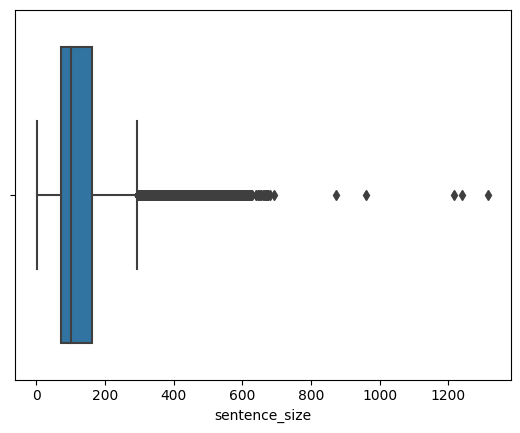

In [15]:
sns.boxplot(x=df_test['sentence_size'])
df_test.sentence_size.describe()

In [16]:

Q1_train = df.sentence_size.quantile(0.25)
Q3_train = df.sentence_size.quantile(0.75)
IQR_train = Q3_train - Q1_train
IQR_train, (Q1_train - 1.5 * IQR_train),(Q3_train + 1.5 * IQR_train), len(df[ df.sentence_size <= (Q3_train + 1.5 * IQR_train)]), len(df[ df.sentence_size > (Q3_train + 1.5 * IQR_train)])


(92.0, -64.0, 304.0, 23183, 1817)

In [17]:
Q1_test = df_test.sentence_size.quantile(0.25)
Q3_test = df_test.sentence_size.quantile(0.75)
IQR_test = Q3_test - Q1_test
IQR_test, (Q1_test - 1.5 * IQR_test),(Q3_test + 1.5 * IQR_test), len(df_test[ df_test.sentence_size <= (Q3_test + 1.5 * IQR_test)]), len(df_test[ df_test.sentence_size > (Q3_test + 1.5 * IQR_test)])


(89.0, -60.5, 295.5, 23151, 1849)

In [18]:
IQR_total = np.minimum((Q3_train + 1.5 * IQR_train),(Q3_test + 1.5 * IQR_test))
sequence_size = int(IQR_total)
sequence_size

295

In [19]:
if ETL_SENTENCE_SIZE == True :
    
    df = check_sentece_size(df,sequence_size)
    df_filtered=df.copy()
    df_filtered = df[df['sentence_size'] > 0] 
    df_filtered = df_filtered.reset_index().drop(["index"], axis = 1)
    
    df_test = check_sentece_size(df_test,sequence_size)
    df_test_filtered=df_test.copy()
    df_test_filtered = df_test[df_test['sentence_size'] > 0] 
    df_test_filtered = df_test_filtered.reset_index().drop(["index"], axis = 1)
    
    
    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(df_filtered.review.values.tolist())
    tokenizer.fit_on_texts(df_test_filtered.review.values.tolist())
    word_frequency= check_word_frequency(tokenizer)
    
    with open('checkpoints/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open('checkpoints/tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
        
    df.to_pickle("./checkpoints/df.pkl")  
    df_test.to_pickle("./checkpoints/df_test.pkl")  
    
    df_filtered.to_pickle("./checkpoints/df_filtered.pkl")  
    df_test_filtered.to_pickle("./checkpoints/df_test_filtered.pkl") 
    
else:
    df = pd.read_pickle("./checkpoints/df.pkl")
    df_test = pd.read_pickle("./checkpoints/df_test.pkl")
    
    df_filtered = pd.read_pickle("./checkpoints/df_filtered.pkl")
    df_test_filtered = pd.read_pickle("./checkpoints/df_test_filtered.pkl")
    
    with open('checkpoints/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open('checkpoints/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
        


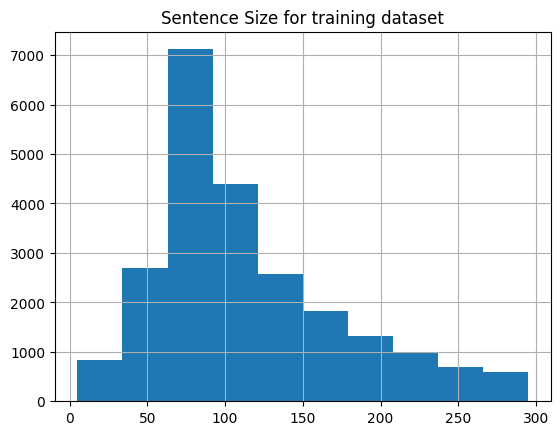

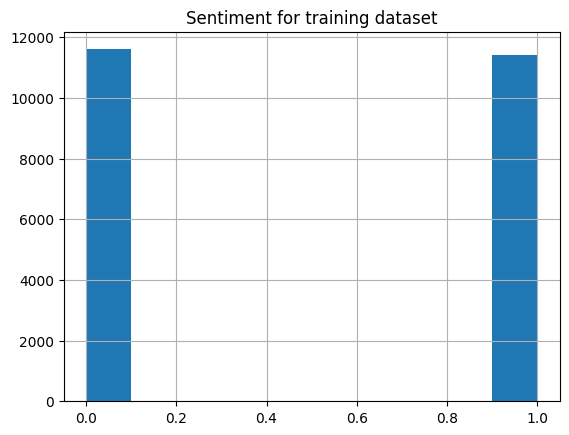

count    23022.000000
mean       113.542872
std         60.148545
min          5.000000
25%         72.000000
50%         96.000000
75%        145.000000
max        295.000000
Name: sentence_size, dtype: float64


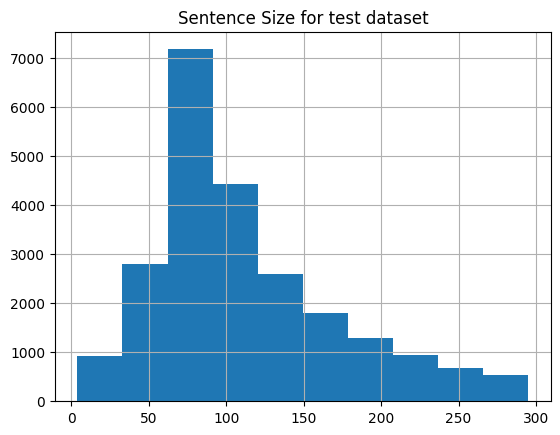

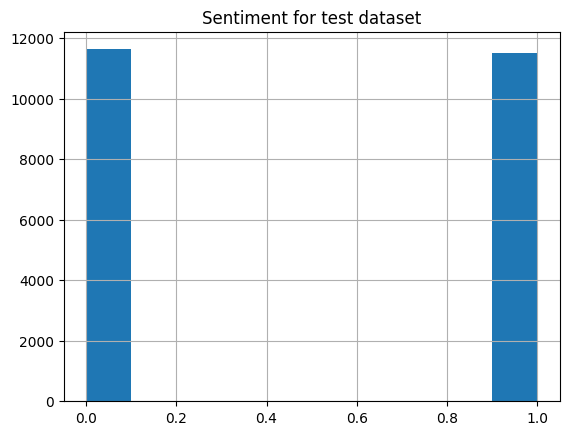

count    23151.000000
mean       111.983327
std         59.382706
min          4.000000
25%         71.000000
50%         95.000000
75%        142.000000
max        295.000000
Name: sentence_size, dtype: float64


In [20]:

plt.figure()
pd.Series(df_filtered.sentence_size).hist()
plt.title("Sentence Size for training dataset")

plt.figure()
pd.Series(df_filtered.sentiment).hist()
plt.title("Sentiment for training dataset")

plt.show()
print(pd.Series(df_filtered.sentence_size).describe())

plt.figure()
pd.Series(df_test_filtered.sentence_size).hist()
plt.title("Sentence Size for test dataset")

plt.figure()
pd.Series(df_test_filtered.sentiment).hist()
plt.title("Sentiment for test dataset")

plt.show()
print(pd.Series(df_test_filtered.sentence_size).describe())

# Deep learning approach

In [35]:
df_filtered.sentiment.unique()

array([0, 1], dtype=int64)

In [36]:
df_filtered = (df_filtered.dropna()).reset_index().drop(["index"], axis = 1)
df_test_filtered = (df_test_filtered.dropna()).reset_index().drop(["index"], axis = 1)
df_test_filtered

,review,sentiment,id,sentence_size
0,go saw movie last night coax friend mine . adm...,1,0,80.0
1,mr . costner drag movie far long necessary . a...,0,1,83.0
2,example majority action film . generic bore re...,0,2,139.0
3,actor turn director bill paxton follow promisi...,1,3,212.0
4,first hate moronic rapper could act gun press ...,0,4,123.0
...,...,...,...,...
23146,basic genre thriller intercut uncomfortable me...,0,24994,150.0
23147,movie complexity subtlety make one thought pro...,1,24996,82.0
23148,four thing intrigue film firstly star carly po...,0,24997,77.0
23149,david bryce comment nearby exceptionally well ...,0,24998,246.0


In [37]:
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
ft.get_dimension()

50

In [38]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
tokenizer.fit_on_texts(df_filtered.review.values.tolist())
tokenizer.fit_on_texts(df_test_filtered.review.values.tolist())
_, vocab_len,sequences,word_index= tokenize_data(tokenizer, df_filtered)
print("Train Vocab length : It should be the complete one : ",vocab_len)
_, vocab_len_test,sequences_test,word_index_test= tokenize_data(tokenizer, df_test_filtered)
print("Test Vocab length. It should be the complete one : ",vocab_len_test)

Train Vocab length : It should be the complete one :  41944
Test Vocab length. It should be the complete one :  41944


In [39]:
embeddings_matrix=get_embeddings_fb(ft,word_index,emb_dim,vocab_len)
print(embeddings_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.07233828  0.05747502 -0.00327877 ...  0.02641198  0.02844513
  -0.00111062]
 [-0.39767951 -0.07395711 -0.3466025  ...  0.35536599  0.27530986
   0.36113474]
 ...
 [ 0.0477251  -0.007656   -0.03468692 ...  0.00538129 -0.06402228
  -0.07430679]
 [ 0.05709544 -0.0521089   0.05927806 ... -0.0081373   0.00663777
   0.00672893]
 [-0.01918651 -0.08906945  0.0336312  ... -0.07835893  0.04539224
   0.02887383]]


In [40]:
x, y = create_trainingdev_set(sequences,df_filtered,sequence_size, False)
x_dev,y_dev,x_test,y_test = create_trainingdev_set(sequences_test,df_test_filtered,sequence_size,True)
y_dev

x shape (23022, 295)
y shape (23022,)
devtest_elements_index length :  11575
x_in shape (11575, 295)
y_in shape (11575,)
x_test shape (11576, 295)
y_test shape (11576,)


array([0., 0., 1., ..., 1., 1., 1.], dtype=float32)

# Start training process

### Run training process 


In [41]:


def get_model_dynamic(best_hps):
    pr = tf.keras.metrics.AUC(curve="PR")
    p = tf.keras.metrics.Precision()
    r = tf.keras.metrics.Recall()

    inp = Input(batch_shape = (None,sequence_size,), name="X")

    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, best_hps["emb_dim"])
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,best_hps["emb_dim"],vocab_len)

    X = Embedding(input_dim = vocab_len, output_dim = best_hps["emb_dim"], input_length = sequence_size ,name ="emb_layer",  weights=[embeddings_matrix_tmp], trainable=False, mask_zero=True) (inp)# Use masking to handle the variable sequence lengths
    #X = SpatialDropout1D(best_hps.get('SpatialDropout1D_1'))(X)
    X = (LSTM(best_hps.get('units_0'),  dropout=best_hps.get('Dropout_0'), return_sequences=False))(X)

    X = BatchNormalization()(X)
    X = Dropout(best_hps.get('Dropout_1'))(X)
    X = Dense(best_hps.get('units_1'), activation='relu')(X)


    Z = Dense(classN, activation='sigmoid')(X)

    model =  Model(inputs = inp, outputs=Z )
    model.summary()

    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=best_hps.get('learning_rate')), metrics =[tf.keras.metrics.BinaryAccuracy(),pr,p,r,tf.keras.metrics.AUC()])

    return model

def get_model_tunning(hp):

    hp_units_0 = hp.Int('units_0', min_value=32, max_value=256, step=32)
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    hp_drop_0 = hp.Choice('Dropout_0', values=[ 0.2, 0.3, 0.4, 0.5])
    hp_drop_1 = hp.Choice('Dropout_1', values=[ 0.2, 0.3, 0.4, 0.5])
    #hp_SpatialDropout1D_1 = hp.Choice('SpatialDropout1D_1', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_emb_dim = hp.Choice('emb_dim', values=[ 50, 100, 200])


    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, hp_emb_dim)
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,hp_emb_dim,vocab_len)


    inp = Input(batch_shape = (None,sequence_size,), name="X")
    
    X = Embedding(input_dim = vocab_len, output_dim = hp_emb_dim, input_length = sequence_size ,name ="emb_layer",  weights=[embeddings_matrix_tmp], trainable=False, mask_zero=True) (inp)# Use masking to handle the variable sequence lengths
    #X = SpatialDropout1D(hp_SpatialDropout1D_1)(X)
    X = (LSTM(hp_units_0, dropout=hp_drop_0, return_sequences=False))(X)

    X = BatchNormalization()(X)
    X = Dropout(hp_drop_1)(X)
    X = Dense(hp_units_1, activation='relu')(X)


    Z = Dense(classN, activation='sigmoid')(X)
    
    model =  Model(inputs = inp, outputs=Z )
    
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=hp_learning_rate), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])
    
    return model


tuner = kt.BayesianOptimization(
        get_model_tunning,
        objective= kt.Objective('val_loss', direction="min"), #kt.Objective('val_auc', direction="max"),# #val_binary_accuracy
        max_trials = max_trials,
        directory=r"Hyperparam_tunning",
        project_name='keras_tunning'
    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)#val_auc
if TUNNING:
    tuner.search(x[0], y,  epochs=300, batch_size=batchsize, validation_data = (x_dev[0],y_dev), verbose =2, callbacks=[stop_early]) 

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps


INFO:tensorflow:Reloading Oracle from existing project Hyperparam_tunning\keras_tunning\oracle.json


INFO:tensorflow:Reloading Tuner from Hyperparam_tunning\keras_tunning\tuner0.json


In [42]:
best_hps["units_0"],best_hps["units_1"],best_hps["Dropout_0"],best_hps["Dropout_0"],best_hps["learning_rate"]
#(64, 64, 0.2, 0.2, 0.5, 0.005)

(32, 256, 0.5, 0.5, 0.005)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X (InputLayer)              [(None, 295)]             0         
                                                                 
 emb_layer (Embedding)       (None, 295, 200)          8388800   
                                                                 
 lstm_1 (LSTM)               (None, 32)                29824     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                           

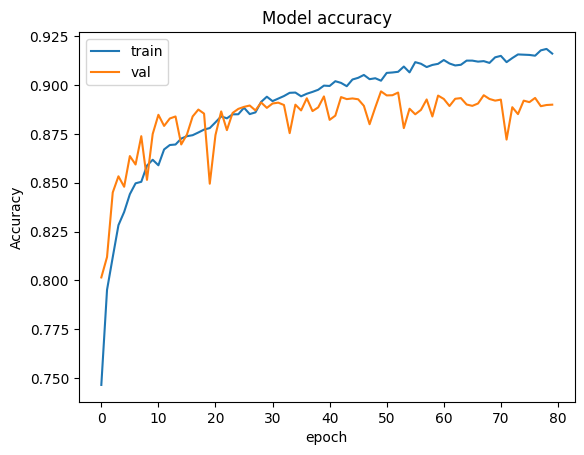

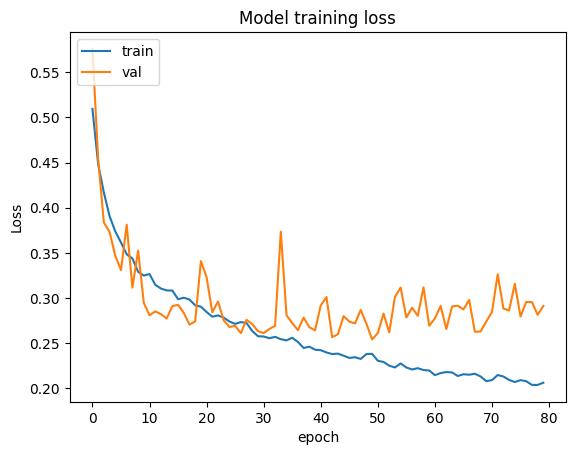

In [43]:
model_dynamic = get_model_dynamic(best_hps)

if FIT_MODEL:
    
    history = model_dynamic.fit(x[0], y, 
              batch_size=batchsize, 
              epochs=300,
              shuffle=True,
              validation_data = (x_dev[0],y_dev),
              callbacks=[PlotLossesCallback() ,stop_early]
             )
    
    model_dynamic.save('./checkpoints_dynamic/model_dynamic')

    with open('./checkpoints_dynamic/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    


else:
    model_dynamic = tf.keras.models.load_model('./checkpoints_dynamic/model_dynamic')

    with open('./checkpoints_dynamic/history.pickle', 'rb') as handle:
        history = pickle.load(handle)
        plt.figure()
        plt.plot(history['binary_accuracy'])
        plt.plot(history['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()

In [44]:
yhat =model_dynamic.predict(x_test[0][0:100])
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
yhat

y_test = y_test.reshape((len(y_test),1))
y_test
print("x 1º line : "+str(x))
print("y : ",y) 
print("y_test : ",y_test) 

4/4 [==============================] - 9s 25ms/step
x 1º line : [array([[   18,    57,  5850, ...,     0,     0,     0],
       [20645,   168,   599, ...,     0,     0,     0],
       [20646,   579,  9335, ...,     0,     0,     0],
       ...,
       [  912,   210,    74, ...,     0,     0,     0],
       [    5,   702,     4, ...,     0,     0,     0],
       [   49,   506,   600, ...,     0,     0,     0]])]
y :  [0. 1. 1. ... 1. 0. 1.]
y_test :  [[1.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [45]:

yhat =model_dynamic.predict(x_test)
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
y_test = y_test.reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")
print()

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

base_pr = pr(y_test, yhat).numpy()
base_p = p.result().numpy()
base_r = r.result().numpy()
print("AUC",base_pr," | Precision : ",base_p, " | Recall : ",base_r)


362/362 [==============================] - 6s 16ms/step

AUC 0.8428497  | Precision :  0.8587062  | Recall :  0.92719376


In [46]:
confusion_matrix(list(y_test),list(yhat))

array([[4943,  878],
       [ 419, 5336]], dtype=int64)

In [47]:

base_tn, base_fp, base_fn, base_tp = confusion_matrix(list(y_test),list(yhat)).ravel()
base_tn, base_fp, base_fn, base_tp



(4943, 878, 419, 5336)

In [48]:
def print_predictions(X, pred):
    for i in range(len(X)):
        xx = [tokenizer.index_word.get(ind) for ind in X[i] if tokenizer.index_word.get(ind) is not None]
        print(' '.join(xx), "Prediction :", int(pred[i])," - Real :",y_test[i][0],"\n")
        
        if i==10:
            break

print_predictions(x_test[0], yhat)

go saw movie last night coax friend mine . admit reluctant see knew ashton kutcher able comedy . wrong . kutcher play character jake fischer well kevin costner played ben randall professionalism . sign good movie toy emotion . one exactly . entire theater sell overcome laughter first half movie move tear second half . exit theater saw many woman tear many full grow men well try desperately let anyone see cry . movie great suggest go see judge . Prediction : 1  - Real : 1.0 

mr . costner drag movie far long necessary . aside terrific sea rescue sequence care character . u ghost closet costner character realize early forget much later time care . character really care cocky overconfident ashton kutcher . problem come kid think good anyone else around show sign cluttered closet . obstacle appear win costner . finally well past half way point stinker costner tell u kutcher ghost . tell kutcher drive best prior inkling foreshadowing . magic could keep turn hour . Prediction : 0  - Real : 0

# Attention model

In [49]:
batchsize = 32
emb_dim = 300
epochs = 100
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
ft.get_dimension()

embeddings_matrix=get_embeddings_fb(ft,word_index,emb_dim,vocab_len)
dataset = tf.data.Dataset.from_tensor_slices((x[0],y.reshape((len(y),1))))
for i,o in dataset.take(3):
    print("Input : ",i.numpy(), " ->",i.numpy().shape)
    print("Output : ",o.numpy(), " ->",o.numpy().shape,"\n\n")
    
    
dataset = dataset.shuffle(buffer_size=10000).batch(batchsize, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
print("Batched dataset ... \n")
for i,o in dataset.take(1):
    print("Input : ",i)
    print("Output : ",o,"\n\n")



val_dataset = tf.data.Dataset.from_tensor_slices((x_dev[0],y_dev.reshape((len(y_dev),1))))
val_dataset = val_dataset.shuffle(buffer_size=10000).batch(batchsize, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

ds_len = len(list(dataset))
val_size = len(list(val_dataset))

train_size = len(list(dataset))

print(ds_len,"-->",train_size,"--->",val_size,"/",ds_len*batchsize)

ds_len = train_size

test_dataset = tf.data.Dataset.from_tensor_slices((x_test[0],y_test.reshape((len(y_test),1))))
test_dataset = test_dataset.batch(1)

Input :  [   18    57  5850   422  3135     2    81   691    25  1087   348  1527
    84     2  8599  5802   180   102  1714   977  2348   754 20644 36671
     2   381   404  1527   134    11   705  1225   807     6   135     2
    19   829   102     2 11174   295    12     6  1436    46   540   728
  6501     2  1619   426     9   148    21     9   495   607    24 28017
 28018     2   607    71  2560 16924 10946  6638     8  2996     2     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0

In [50]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence, figsize  =(10, 10)):
  sentence = sentence.split()
  predicted_sentence = predicted_sentence.split() + ['<eos>']
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [51]:

class SelfMaskedDotProductAttention(tf.keras.Model): 
    def __init__(self):
        super(SelfMaskedDotProductAttention, self).__init__()


    def call(self, q, k, v, padding_mask= None, look_ahead_mask= None):
        
        PRINT_SHAPE= False
                
        matmul_qk = tf.matmul(q, k, transpose_b=True) 

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if PRINT_SHAPE : print("weight shape : ", scaled_attention_logits.shape," - [batch_size, Tq, Tv]")
        
        if padding_mask is not None:
            padding_mask = tf.expand_dims(padding_mask, 1)
            scaled_attention_logits = tf.where(padding_mask, scaled_attention_logits, tf.experimental.numpy.full_like(scaled_attention_logits,  -1e9))

        if look_ahead_mask is not None:
            scaled_attention_logits += (look_ahead_mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
        if PRINT_SHAPE : print("attention_weights / values : ",attention_weights.shape, v.shape)

        context_vector = tf.matmul(attention_weights, v)

        if PRINT_SHAPE : print("context_vector shape : ", context_vector.shape)

        return context_vector, attention_weights


class MaskedLossCustom(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_custom'
    self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

  def __call__(self, y_true, y_pred):

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)
    
auc = tf.keras.metrics.AUC(curve="PR")
p = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()



class Sentiment_Attention_v2(tf.keras.Model):
    def __init__(self, unit_lstm, unit_dropout_1, unit_dropout_2, unit_dense, vocab_len, emb_dim, embeddings_matrix, classes, input_length, causal_mask_enabled=True):
        super(Sentiment_Attention_v2, self).__init__()

        
        self.embedding_layer = Embedding(input_dim = vocab_len, output_dim = emb_dim, input_length = input_length ,name ="emb_layer",  weights=[embeddings_matrix], trainable=False, mask_zero=True)# Use masking to handle the variable sequence lengths
        self.lstm = LSTM(unit_lstm,  return_sequences=True, dropout=unit_dropout_1, return_state = True)#dropout=0.5,  1024
        self.batch_norm = BatchNormalization()
        self.drop = Dropout(unit_dropout_2)
        self.d0 = Dense(unit_dense, activation='relu')
        self.d = Dense(classes, activation='sigmoid')

        self.dot_attention = SelfMaskedDotProductAttention()
        self.causal_mask_enabled = causal_mask_enabled


    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  
    
    def call(self, inputs):
        input_mask = (inputs != 0)
        x = self.embedding_layer(inputs)

        lstm_out, h_state, c_state = self.lstm(x) 

        if self.causal_mask_enabled == False :
            look_ahead_mask = None
        else:
            look_ahead_mask = self.create_look_ahead_mask(tf.shape(inputs)[1])

        context_vector, attention_weights = self.dot_attention(lstm_out, lstm_out, lstm_out, input_mask, look_ahead_mask)
        x = tf.reduce_sum(context_vector, axis = 1)
        x = self.batch_norm(x)
        x = self.drop(x)
        x = self.d0(x)
        pred = self.d(x)
                       
        return pred

    def predict_sentiment(self, inputs):
        input_mask = (inputs != 0)
        x = self.embedding_layer(inputs)

        lstm_out, h_state, c_state = self.lstm(x) 

        if self.causal_mask_enabled == False :
            look_ahead_mask = None
        else:
            look_ahead_mask = self.create_look_ahead_mask(tf.shape(inputs)[1])

        context_vector, attention_weights = self.dot_attention(lstm_out, lstm_out, lstm_out, input_mask, look_ahead_mask)
        x = tf.reduce_sum(context_vector, axis = 1)
        x = self.batch_norm(x)
        x = self.drop(x)
        x = self.d0(x)
        pred = self.d(x)
                       
        return pred, attention_weights, context_vector 



C:\Users\yanie\AppData\Local\Temp\ipykernel_14760\2653048329.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\yanie\AppData\Local\Temp\ipykernel_14760\2653048329.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


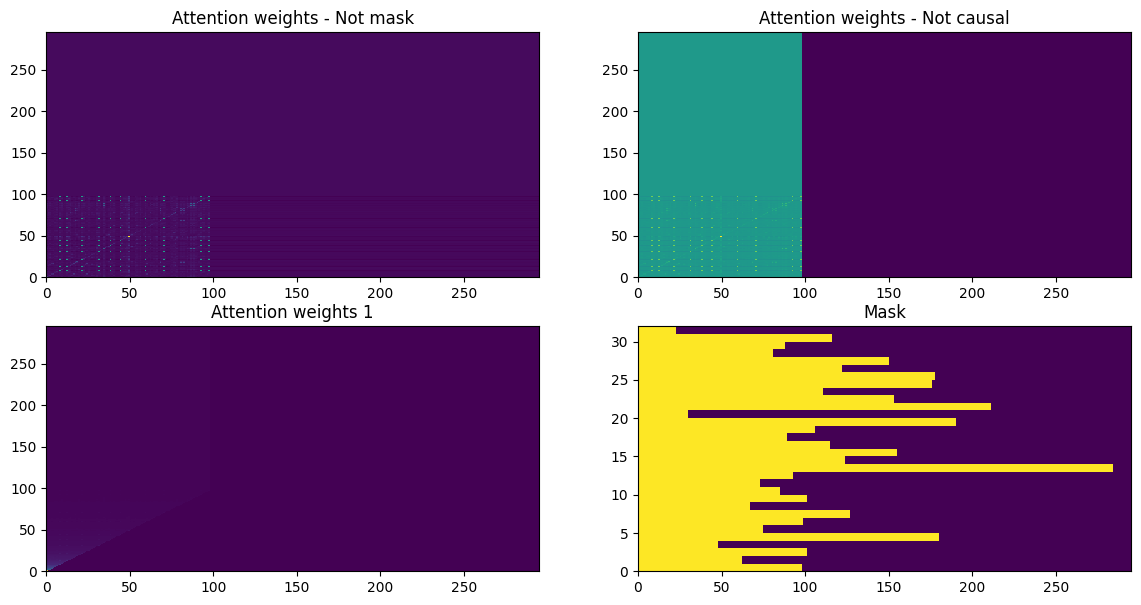

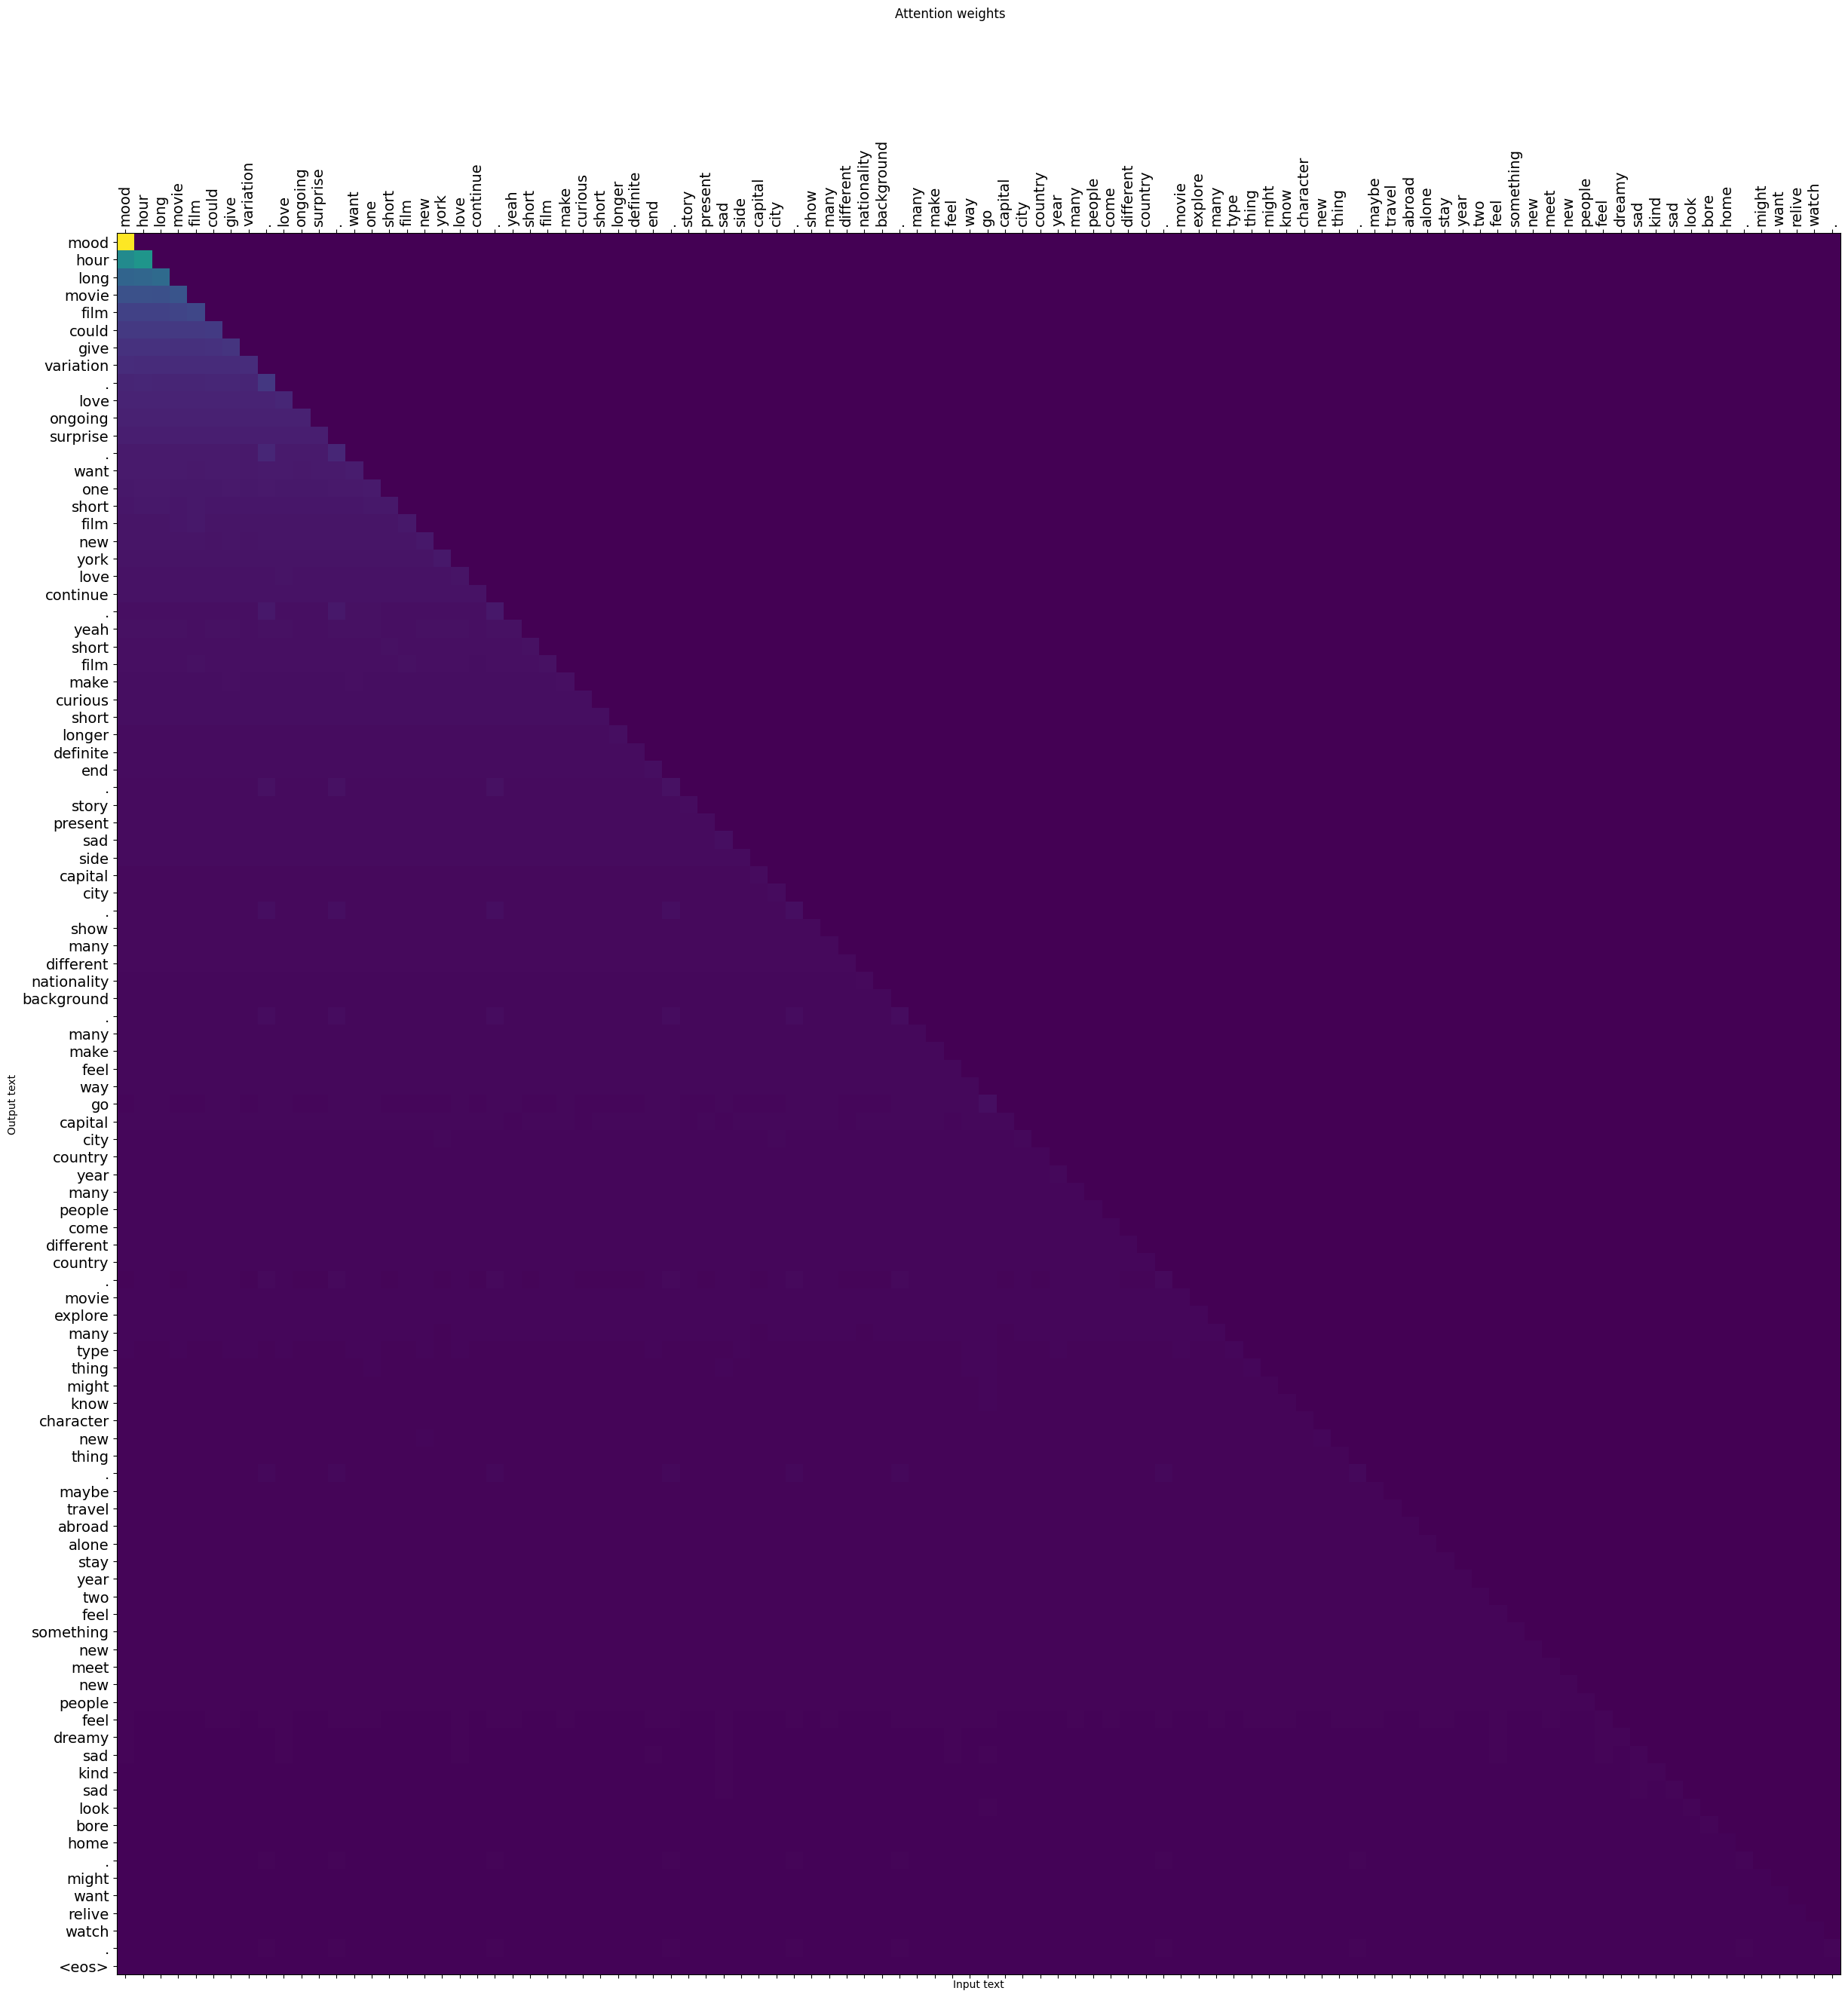

In [52]:
emb_layer = Embedding(input_dim=vocab_len, input_length = sequence_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)
attention_layer = SelfMaskedDotProductAttention()
query = emb_layer(i)
values = emb_layer(i)

context_vector, attention_weights_nomask = attention_layer(query,values,values)
context_vector, attention_weights = attention_layer(query,values,values, padding_mask=(i != 0))
context_vector, attention_weightsv2 = attention_layer(query,values,values, padding_mask=(i != 0), look_ahead_mask= (1 - tf.linalg.band_part(tf.ones((i.shape[1], i.shape[1])), -1, 0)))

plt.figure(figsize=(14,7))
plt.subplot(2, 2, 1)
plt.pcolormesh(attention_weights_nomask[0])#[ :mask_size,:mask_size]
plt.title('Attention weights - Not mask')

plt.subplot(2, 2, 2)
plt.pcolormesh(attention_weights[0])#[ :mask_size,:mask_size]
plt.title('Attention weights - Not causal')

plt.subplot(2, 2, 3)
plt.pcolormesh(attention_weightsv2[0])#[ :mask_size,:mask_size]
plt.title('Attention weights 1')

plt.subplot(2, 2, 4)
plt.pcolormesh(i != 0)
plt.title('Mask')

sentence = ' '.join([tokenizer.index_word.get(ind.numpy()) for ind in i[0] if tokenizer.index_word.get(ind.numpy()) is not None])
plot_attention(attention_weightsv2[0], sentence, sentence, figsize  =(30, 30))

In [53]:


def get_attention_v2_tunning(hp):

    hp_unit_lstm = hp.Int('unit_lstm', min_value=32, max_value=512, step=32)
    hp_unit_dropout_1 = hp.Choice('unit_dropout_1', values=[ 0.1, 0.3, 0.5])
    hp_unit_dropout_2 = hp.Choice('unit_dropout_2', values=[ 0.1, 0.3, 0.5])
    hp_unit_dense = hp.Int('unit_dense', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])

    hp_emb_dim = hp.Choice('emb_dim', values=[ 100, 200, 300])


    ft = fasttext.load_model('../cc.en.300.bin')
    fasttext.util.reduce_model(ft, hp_emb_dim)
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,hp_emb_dim,vocab_len)

    model = Sentiment_Attention_v2(hp_unit_lstm, hp_unit_dropout_1, hp_unit_dropout_2, hp_unit_dense, vocab_len, hp_emb_dim, embeddings_matrix_tmp, classN, sequence_size, causal_mask_enabled=True)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=hp_learning_rate), metrics =[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])
    
    return model


tuner_att_v2 = kt.BayesianOptimization(
        get_attention_v2_tunning,
        objective= kt.Objective('val_loss', direction="min"), #kt.Objective('val_auc', direction="max"),# #val_binary_accuracy
        max_trials = max_trials,
        directory=r"Hyperparam_att_v2_tunning",
        project_name='Hyperparam_att_v2_tunning',
    )


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

if TUNNING_ATTENTION_V2:
    tuner_att_v2.search(dataset,  epochs=100, batch_size=batchsize, validation_data = val_dataset, verbose =2, callbacks=[stop_early]) 


best_hps_att_v2=tuner_att_v2.get_best_hyperparameters(num_trials= 1)[0]
best_hps_att_v2


INFO:tensorflow:Reloading Oracle from existing project Hyperparam_att_v2_tunning\Hyperparam_att_v2_tunning\oracle.json


INFO:tensorflow:Reloading Tuner from Hyperparam_att_v2_tunning\Hyperparam_att_v2_tunning\tuner0.json


In [54]:
best_hps_att_v2["emb_dim"],best_hps_att_v2["unit_lstm"],best_hps_att_v2["unit_dropout_1"],best_hps_att_v2["unit_dropout_2"],best_hps_att_v2["unit_dense"], best_hps_att_v2["learning_rate"]

(300, 32, 0.5, 0.5, 320, 0.001)

Loading saved data ...


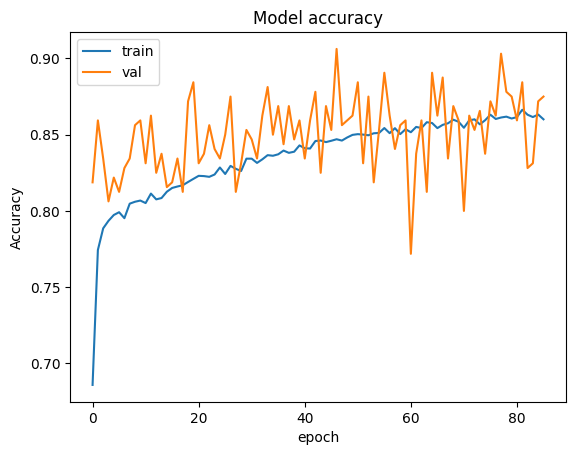

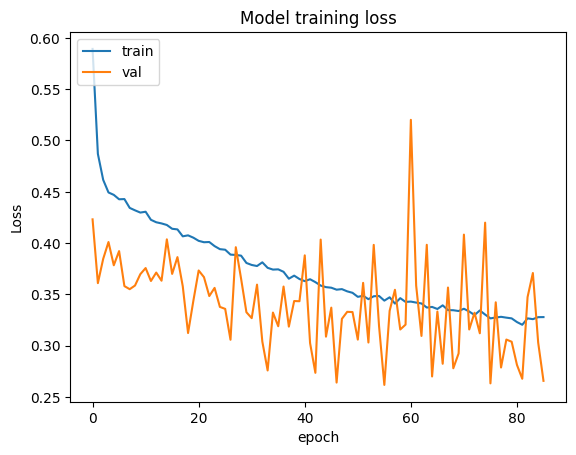

In [55]:
emb_dim_tmp= best_hps_att_v2["emb_dim"]
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim_tmp)
embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,emb_dim_tmp,vocab_len)
lr = 0.0001 # best_hps_att_v2["learning_rate"]

sentiment_MODEL_V2 = Sentiment_Attention_v2(
        unit_lstm = best_hps_att_v2["unit_lstm"], 
        unit_dropout_1= best_hps_att_v2["unit_dropout_1"], 
        unit_dropout_2 = best_hps_att_v2["unit_dropout_2"], 
        unit_dense = 256,#best_hps_att_v2["unit_dense"], 
        vocab_len = vocab_len, 
        emb_dim = emb_dim_tmp,
        embeddings_matrix =  embeddings_matrix_tmp, 
        classes = classN, 
        input_length = sequence_size,
        causal_mask_enabled=False)

sentiment_MODEL_V2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate=lr),
 metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])#Adam(learning_rate=best_hps.get('learning_rate'))

if FIT_ATTENTION_MODELV2:
    
    history_attention = sentiment_MODEL_V2.fit( 
                dataset,
                batch_size = batchsize, 
                epochs= 300,#epochs*2,#epochs,#400
                shuffle=True,
                callbacks=[PlotLossesCallback(), stop_early], 
                validation_data=val_dataset, 
                validation_steps=10)


    sentiment_MODEL_V2.save_weights("./checkpoints_att/sentiment_attention_model_ckpt.ckpt")
    
    with open('./checkpoints_att/history_attention.pickle', 'wb') as handle:
        pickle.dump(history_attention.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:

    print("Loading saved data ...")
    sentiment_MODEL_V2.load_weights("./checkpoints_att/sentiment_attention_model_ckpt.ckpt")

    with open('./checkpoints_att/history_attention.pickle', 'rb') as handle:
        history_attention = pickle.load(handle)
        plt.figure()
        plt.plot(history_attention['binary_accuracy'])
        plt.plot(history_attention['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_attention['loss'])
        plt.plot(history_attention['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()


In [56]:
if MAKE_PREDICTION:
    y_hat_list = []
    counter= 0
    for i, o in test_dataset.take(len(x_test[0])):
        if counter%1000 ==0 :
            print(counter)

        yhat, attention_weightsv2, context_vector = sentiment_MODEL_V2.predict_sentiment(i)
        y_hat_list.append(int(yhat[0].numpy()[0] >=0.5))
        counter +=1
        
    y_test = y_test.reshape((len(y_test),1))
    yhat = np.array(y_hat_list).reshape((len(y_test),1))

    pr_attv2 = tf.keras.metrics.AUC(curve="PR")

    p_attv2 = tf.keras.metrics.Precision()
    p_attv2.update_state(y_test,yhat)

    r_attv2 = tf.keras.metrics.Recall()
    r_attv2.update_state(y_test,yhat)
    
    pr_vr = pr_attv2(y_test, yhat).numpy()
    p_v2 = p_attv2.result().numpy()
    r_v2 = r_attv2.result().numpy()
    print(f"With Attention V2 : AUC {pr_vr} | Precision : {p_v2} | Recall : {r_v2}")
    print("Without Attention : AUC ",base_pr,"  | Precision :  ",base_p,"  | Recall :  ",base_r)


    tn_attv2, fp_attv2, fn_attv2, tp_attv2 = confusion_matrix(list(y_test),list(yhat)).ravel()
    print(f"With Attention V2: True Negative = {tn_attv2}, False Positive : {fp_attv2}, False Negative : {fn_attv2}, True Positive : {tp_attv2}")
    print(f"Without Attention : True Negative = {base_tn}, False Positive : {base_fp}, False Negative : {base_fn}, True Positive : {base_tp}")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
With Attention V2 : AUC 0.852476179599762 | Precision : 0.8870503306388855 | Recall : 0.8569939136505127
Without Attention : AUC  0.8428497   | Precision :   0.8587062   | Recall :   0.92719376
With Attention V2: True Negative = 5193, False Positive : 628, False Negative : 823, True Positive : 4932
Without Attention : True Negative = 4943, False Positive : 878, False Negative : 419, True Positive : 5336


C:\Users\yanie\AppData\Local\Temp\ipykernel_14760\2653048329.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\yanie\AppData\Local\Temp\ipykernel_14760\2653048329.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


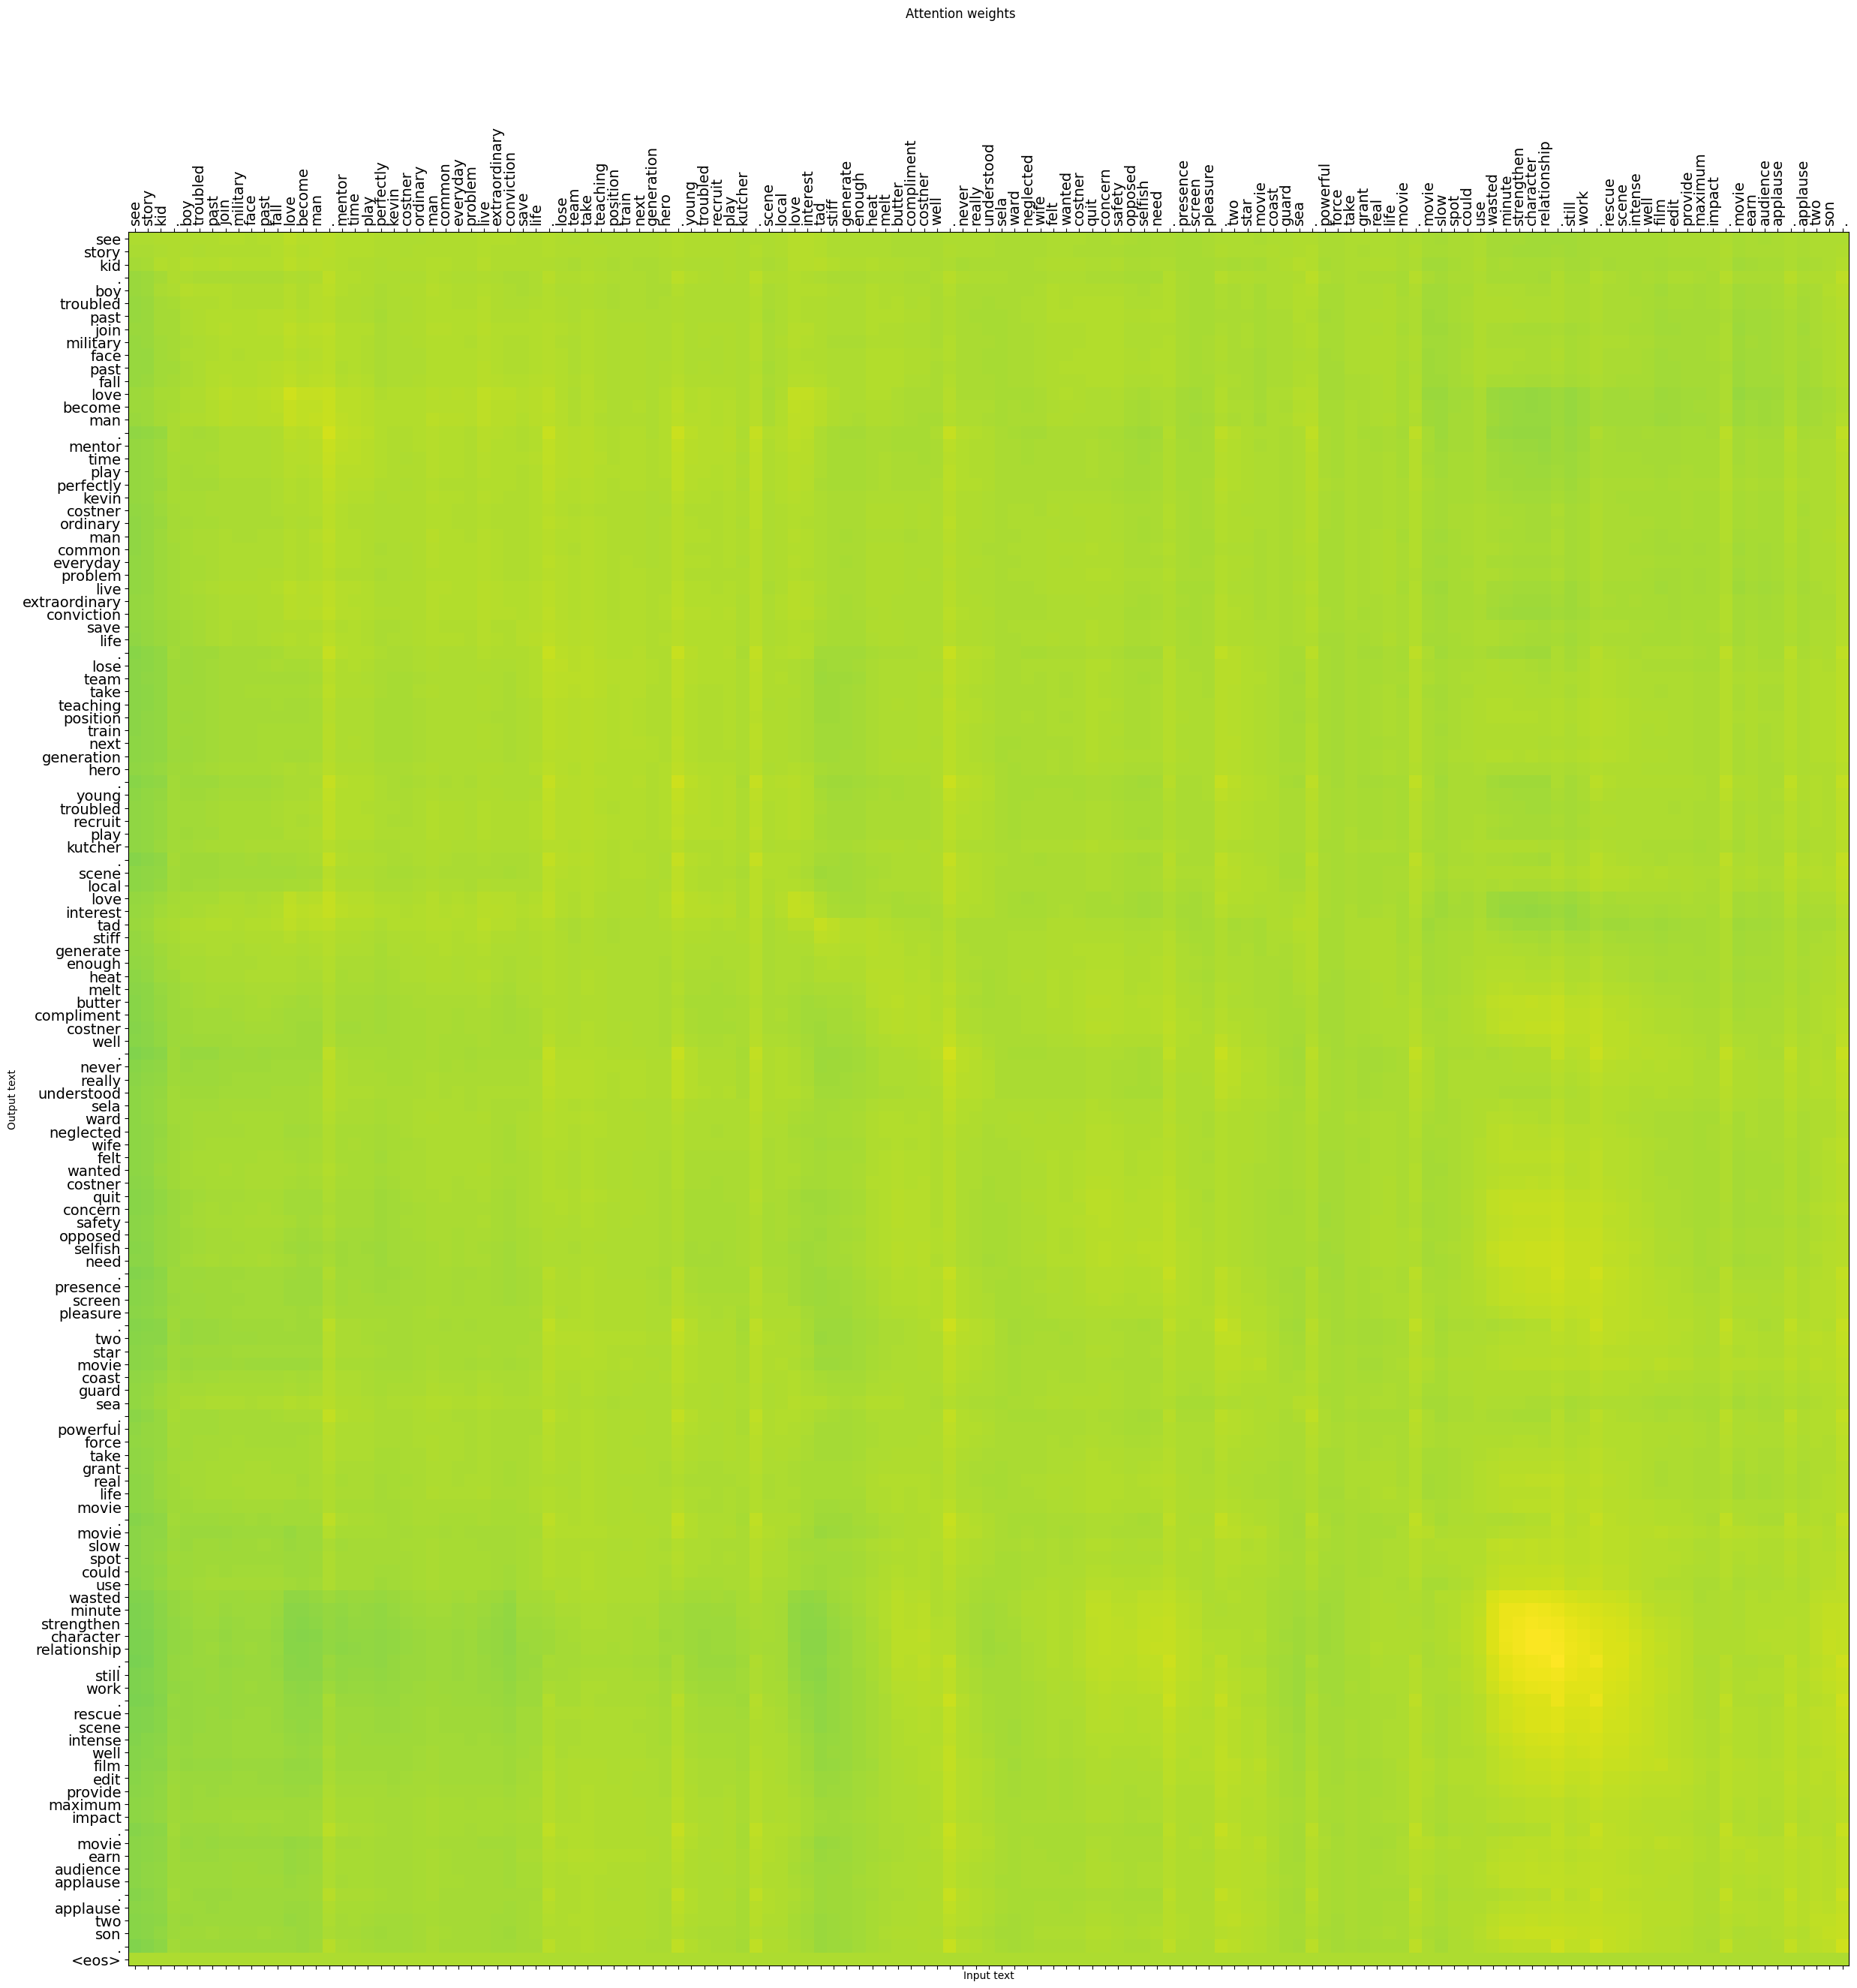

In [57]:
if MAKE_PREDICTION:
    sentence = ' '.join([tokenizer.index_word.get(ind.numpy()) for ind in i[0] if tokenizer.index_word.get(ind.numpy()) is not None])
    plot_attention(attention_weightsv2[0], sentence, sentence, figsize  =(30, 30))

In [58]:
if MAKE_PREDICTION: print_predictions(x_test[0], yhat)

go saw movie last night coax friend mine . admit reluctant see knew ashton kutcher able comedy . wrong . kutcher play character jake fischer well kevin costner played ben randall professionalism . sign good movie toy emotion . one exactly . entire theater sell overcome laughter first half movie move tear second half . exit theater saw many woman tear many full grow men well try desperately let anyone see cry . movie great suggest go see judge . Prediction : 1  - Real : 1.0 

mr . costner drag movie far long necessary . aside terrific sea rescue sequence care character . u ghost closet costner character realize early forget much later time care . character really care cocky overconfident ashton kutcher . problem come kid think good anyone else around show sign cluttered closet . obstacle appear win costner . finally well past half way point stinker costner tell u kutcher ghost . tell kutcher drive best prior inkling foreshadowing . magic could keep turn hour . Prediction : 0  - Real : 0

# Transformer Decoder


In [59]:
batch_size = 32#100
emb_dim = 300
num_heads= 2
dropout_rate= 0.2
num_layers= 1
dff= 32
lr = 0.0001

ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
embeddings_matrix=get_embeddings_fb(ft,word_index,emb_dim,vocab_len)

In [60]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x, attn_output

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1,epsilon=1e-6):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x , attn_weights_block1= self.self_attention(x)
    x = self.ffn(x)
    return x, attn_weights_block1

In [61]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, embeddings_matrix, window_size, vocab_len, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=d_model, weights=[embeddings_matrix] ,name ="emb_layer2", trainable=False, mask_zero = True)#
    self.pos_encoding = positional_encoding(length=2048, depth = d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x
    
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, embeddings_matrix , window_size, 
  num_heads,   dff, vocab_len, rate=0.1, epsilon=1e-6):

    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(embeddings_matrix, window_size = window_size, vocab_len=vocab_len, d_model=d_model)

    self.enc_layers = [EncoderLayer(d_model=d_model,num_heads=num_heads,dff=dff, rate=rate)for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)
    attention_weights = {}

    for i in range(self.num_layers):
      x, block1 = self.enc_layers[i](x)
      attention_weights[f'decoder_layer{i+1}_block1'] = block1
  
    return x, attention_weights # Shape `(batch_size, seq_len, d_model)`.


In [62]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model,embeddings_matrix,window_size, num_heads, dff,  vocab_len, rate=0.1, use_tf_function= True, epsilon=1e-6):
        super().__init__()

        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, embeddings_matrix = embeddings_matrix,
                            window_size= window_size, num_heads=num_heads, dff=dff, vocab_len=vocab_len, rate=rate, epsilon=epsilon)
        
        self.use_tf_function = use_tf_function
        self.final_layer = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs, training=True):
        # Keras models prefer if you pass all your inputs in the first argument
        inp = inputs
        x, attention_weights = self.encoder(inp)
        x = tf.reduce_sum(x, axis = 1)
        enc_output = self.final_layer(x)
        
        return enc_output

    def predict_on(self, inputs, training=False):
        # Keras models prefer if you pass all your inputs in the first argument
        inp = inputs
        x, attention_weights = self.encoder(inp)
        x = tf.reduce_sum(x, axis = 1)
        enc_output = self.final_layer(x)
        return enc_output, attention_weights



In [63]:

def get_transformer_tunning(hp):

    hp_dff = hp.Int('dff', min_value=32, max_value=512, step=32)
    hp_unit_dropout_rate = hp.Choice('dropout_rate', values=[ 0.1, 0.3, 0.5])
    hp_num_heads = hp.Choice('num_heads', values=[1, 2, 3, 4])
    hp_num_layers= hp.Int('num_layers', min_value=1, max_value=4, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001,  0.0001])

    ft = fasttext.load_model('../cc.en.300.bin')
    hp_emb_dim = hp.Choice('emb_dim', values=[50, 100, 150])
    fasttext.util.reduce_model(ft, hp_emb_dim)
    embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,hp_emb_dim,vocab_len)

    transformer = Transformer(
        num_layers=hp_num_layers,
        d_model=hp_emb_dim,
        embeddings_matrix = embeddings_matrix_tmp,
        window_size = sequence_size,
        num_heads=hp_num_heads,
        dff=hp_dff,
        vocab_len=vocab_len,
        rate=hp_unit_dropout_rate)

    optimizer = tf.keras.optimizers.Adam(hp_learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
    transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=optimizer, metrics=[ tf.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])#,"accuracy"  tf.keras.losses.BinaryCrossentropy(from_logits=False), tf.metrics.BinaryAccuracy()

    
    return transformer

tuner_transformer = kt.BayesianOptimization(
        get_transformer_tunning,
        objective= kt.Objective('val_auc', direction="max"), #kt.Objective('val_auc', direction="max"),# #val_binary_accuracy
        max_trials = max_trials,
        directory=r"Hyperparam_transformer_tunning",
        project_name='Hyperparam_transformer_tunning',
    )
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=60)

if TUNNING_TRANSFORMER:
    tuner_transformer.search(dataset,  epochs=100, batch_size=batchsize, shuffle= True,validation_data = val_dataset, verbose =2, callbacks=[stop_early]) #epochs


best_hps_transformer=tuner_transformer.get_best_hyperparameters(num_trials=1)[0]
best_hps_transformer["emb_dim"], best_hps_transformer["num_layers"],best_hps_transformer["num_heads"],best_hps_transformer["dff"],best_hps_transformer["dropout_rate"]
#(100, 2, 3, 256, 0.1, 0.0001)

Trial 19 Complete [00h 53m 44s]
val_auc: 0.9383777976036072

Best val_auc So Far: 0.9468340277671814
Total elapsed time: 17h 11m 03s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
448               |288               |dff
0.1               |0.1               |dropout_rate
2                 |1                 |num_heads
1                 |2                 |num_layers
0.0001            |0.0001            |learning_rate
150               |150               |emb_dim



Epoch 1/100
719/719 - 38s - loss: 5.6943 - binary_accuracy: 0.6825 - auc: 0.7083 - val_loss: 10.5505 - val_binary_accuracy: 0.5287 - val_auc: 0.5495 - 38s/epoch - 53ms/step
Epoch 2/100
719/719 - 38s - loss: 2.7156 - binary_accuracy: 0.7388 - auc: 0.7761 - val_loss: 1.3430 - val_binary_accuracy: 0.7940 - val_auc: 0.8613 - 38s/epoch - 53ms/step
Epoch 3/100
719/719 - 39s - loss: 1.9468 - binary_accuracy: 0.7546 - auc: 0.8026 - val_loss: 1.1496 - val_binary_accuracy: 0.7948 - val_auc: 0.8747 - 39s/epoch - 55ms/step
Epoch 4/100
719/719 - 39s - loss: 1.3955 - binary_accuracy: 0.7649 - auc: 0.8230 - val_loss: 2.1304 - val_binary_accuracy: 0.6646 - val_auc: 0.8099 - 39s/epoch - 55ms/step
Epoch 5/100
719/719 - 39s - loss: 1.2300 - binary_accuracy: 0.7675 - auc: 0.8306 - val_loss: 1.4123 - val_binary_accuracy: 0.7069 - val_auc: 0.8644 - 39s/epoch - 54ms/step
Epoch 6/100
719/719 - 39s - loss: 0.9000 - binary_accuracy: 0.7755 - auc: 0.8500 - val_loss: 1.5614 - val_binary_accuracy: 0.6504 - val_auc

In [ ]:
emb_dim = best_hps_transformer["emb_dim"]
ft = fasttext.load_model('../cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
embeddings_matrix_tmp=get_embeddings_fb(ft,word_index,emb_dim,vocab_len)

transformer = Transformer(
    num_layers=best_hps_transformer["num_layers"],
    d_model=emb_dim,
    embeddings_matrix = embeddings_matrix_tmp,
    window_size = sequence_size,
    num_heads=best_hps_transformer["num_heads"],
    dff=best_hps_transformer["dff"],
    vocab_len=vocab_len,
    rate=best_hps_transformer["dropout_rate"]
    )

for i, o in dataset.take(1):
    print(i.shape, o.shape)
    fn_out = transformer(i, training=False)
    _,_ = transformer.predict_on(i, training=False)
    print
fn_out.shape  

In [ ]:
best_hps_transformer["emb_dim"], best_hps_transformer["num_layers"],best_hps_transformer["num_heads"],best_hps_transformer["dff"],best_hps_transformer["dropout_rate"],best_hps_transformer["learning_rate"]

In [ ]:
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
optimizer=tf.keras.optimizers.Adam(best_hps_transformer["learning_rate"]/2), 
metrics=[tf.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])


model_check = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints_transformer/transf_ckpt",
    monitor= 'val_auc',
    verbose =  0,
    save_best_only =  True,
    save_weights_only = True,
    mode = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

In [ ]:
if FIT_TRANSFORMER_MODEL:
    
    history_transformer = transformer.fit(dataset, epochs=100, shuffle= True, batch_size = batchsize, #stop_early
                            steps_per_epoch = train_size, callbacks=[model_check, PlotLossesCallback(), stop_early], validation_data=val_dataset, verbose = 2) #,  validation_steps=10   PlotLossesCallback(),
    
    transformer.save_weights("./checkpoints_transformer/transformer_ckpt")

    with open('./checkpoints_transformer/history_transformer.pickle', 'wb') as handle:
        pickle.dump(history_transformer.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Loading saved data ...")
    transformer.load_weights("./checkpoints_transformer/transformer_ckpt")

    with open('./checkpoints_transformer/history_transformer.pickle', 'rb') as handle:
        history_transformer = pickle.load(handle)
        plt.figure()
        plt.plot(history_transformer['binary_accuracy'])
        plt.plot(history_transformer['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['loss'])
        plt.plot(history_transformer['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

In [ ]:
y_hat_list = []
counter= 0
yhat=None
for i, o in test_dataset.take(len(x_test[0])):
    if counter%1000 ==0 :
        print(counter)
    yhat, attention_weights = transformer.predict_on(i)
    y_hat_list.append(int(yhat[0].numpy()[0] >=0.5))
    counter +=1

y_test = y_test.reshape((len(y_test),1))
yhat = np.array(y_hat_list).reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

print("With Transformers : AUC",pr(y_test, yhat).numpy()," | Precision : ",p.result().numpy(), " | Recall : ",r.result().numpy())
print(f"With Attention V2 : AUC {pr_vr} | Precision : {p_v2} | Recall : {r_v2}")
print("Without Attention : AUC ",base_pr,"  | Precision :  ",base_p,"  | Recall :  ",base_r)

tn, fp, fn, tp = confusion_matrix(list(y_test),list(yhat)).ravel()
print(f"With Transformer : True Negative = {tn}, False Positive : {fp}, False Negative : {fn}, True Positive : {tp}")
print(f"With Attention V2: True Negative = {tn_attv2}, False Positive : {fp_attv2}, False Negative : {fn_attv2}, True Positive : {tp_attv2}")
print(f"Without Attention : True Negative = {base_tn}, False Positive : {base_fp}, False Negative : {base_fn}, True Positive : {base_tp}")

In [ ]:
if MAKE_PREDICTION:
    sentence = ' '.join([tokenizer.index_word.get(ind.numpy()) for ind in i[0] if tokenizer.index_word.get(ind.numpy()) is not None])
    plot_attention(attention_weightsv2[0], sentence, sentence, figsize  =(30, 30))